In [1]:
%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (8.0, 10.0)

In [4]:
# Move Exported COCO data to: <repo>/PythonAPI/coco/
# dataDir='./orientation.hammerhead.coco'
# dataDir='./orientation.mantaray.coco'
# dataDir='./orientation.rightwhale.coco'
# dataDir='./orientation.seadragon.coco'
# dataDir='./orientation.seaturtle.coco'
# dataDir='./orientation.spotteddolphin.coco'
dataDir='/home/olga/Documents/Datasets/WildMe/orientation.mantaray.coco'
dataType='val2020'
annFile='{}/annotations/instances_{}.json'.format(dataDir,dataType)

In [5]:
# initialize COCO api for instance annotations
coco=COCO(annFile)

loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


In [6]:
# display COCO categories and supercategories
cats = coco.loadCats(coco.getCatIds())
nms = [cat['name'] for cat in cats]
print('COCO categories: \n{}\n'.format(' '.join(nms)))

nms = set([cat['supercategory'] for cat in cats])
print('COCO supercategories: \n{}'.format(' '.join(nms)))

COCO categories: 
manta_ray_giant

COCO supercategories: 
animal


In [7]:
cats

[{'id': 0, 'name': 'manta_ray_giant', 'supercategory': 'animal'}]

In [8]:
len(coco.anns)

1215

{'license': 3, 'file_name': '000000000039.jpg', 'coco_url': None, 'height': 1800, 'width': 2400, 'date_captured': '2014-09-07 14:02:56', 'flickr_url': None, 'id': 39, 'uuid': 'bc84c04d-63e6-42be-b5a4-a01662d0dc0f'}


[{'bbox': [359.765625, 555.46875, 2037.890625, 1000.78125],
  'theta': 0.0,
  'viewpoint': 'back',
  'segmentation': [[360, 555, 2398, 555, 2398, 1556, 360, 1556, 360, 555]],
  'segmentation_bbox': [360, 555, 2038, 1001],
  'area': 2040038,
  'iscrowd': 0,
  'id': 39,
  'image_id': 39,
  'category_id': 0,
  'uuid': '3b9c4270-ce36-46ac-a518-a972006380c4',
  'isinterest': 1,
  'name': '____',
  'review_ids': []}]

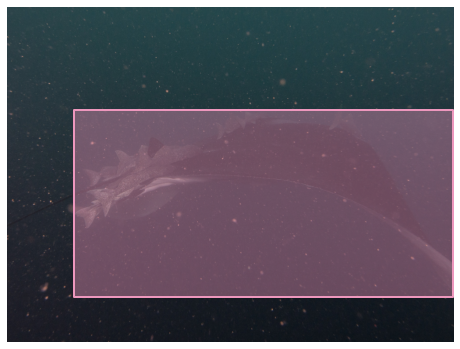

In [9]:
# load and display instance annotations
catIds = coco.getCatIds(catNms=nms);
imgIds = coco.getImgIds(catIds=catIds);
img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]
#img = coco.loadImgs(8)[0]
print(img)

I = io.imread('%s/images/%s/%s'%(dataDir,dataType,img['file_name']))
plt.imshow(I); plt.axis('off')
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
anns = coco.loadAnns(annIds)
coco.showAnns(anns)
anns

Challenges:
* coordinates of oriented box may go beyond image boundaries
* many images are close view. Creating training data with rotation may be biased
* 

In [10]:
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon

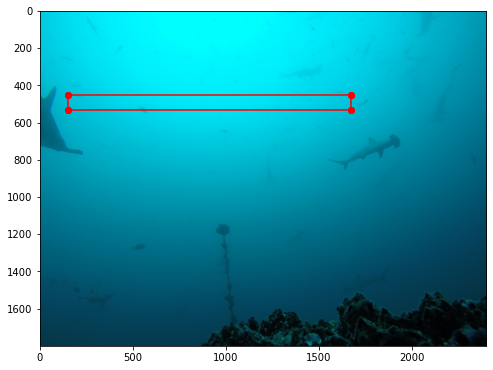

In [119]:
fig, ax = plt.subplots()
#ax.set_autoscale_on(False)
elem = anns[0]
filename = img['file_name']
image = io.imread('%s/images/%s/%s'%(dataDir,dataType,filename))
plt.imshow(image)

#Get theta
theta = elem['theta']

#Plot 'bbox' annotation
bbox = elem['bbox']
plt.plot([bbox[0], bbox[2]], [bbox[1], bbox[1]], '-ro')
plt.plot([bbox[0], bbox[2]], [bbox[3], bbox[3]], '-ro')
plt.plot([bbox[0], bbox[0]], [bbox[1], bbox[3]], '-ro')
plt.plot([bbox[2], bbox[2]], [bbox[1], bbox[3]], '-ro')

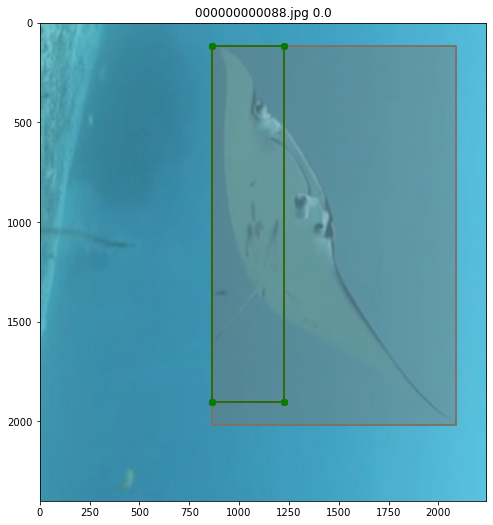

In [110]:
#Plot 'segmentation_bbox' annotation
sbbox = elem['segmentation_bbox']
plt.plot([sbbox[0], sbbox[2]], [sbbox[1], sbbox[1]], '-go')
plt.plot([sbbox[0], sbbox[2]], [sbbox[3], sbbox[3]], '-go')
plt.plot([sbbox[0], sbbox[0]], [sbbox[1], sbbox[3]], '-go')
plt.plot([sbbox[2], sbbox[2]], [sbbox[1], sbbox[3]], '-go')

#Plot 'segmentation' annotation
polygons=[]
color = [(np.random.random((1, 3))*0.6+0.4).tolist()[0]]
#ax = plt.gca()

segm = elem['segmentation'][0]
poly = np.array(segm).reshape((int(len(segm)/2), 2))
polygons.append(Polygon(poly))
p = PatchCollection(polygons, facecolor=color, linewidths=0, alpha=0.4)
ax.add_collection(p)
p = PatchCollection(polygons, facecolor='none', edgecolors=color, linewidths=2)
ax.add_collection(p)
#plt.plot([segm[0], segm[2], segm[4], segm[6], segm[8]], [segm[1], segm[3], segm[5], segm[7], segm[9]], 'ro')

plt.title('{} {}'.format(filename, theta))
plt.show()

# Analyse dataset

In [15]:
counter = 0
for ann_id, annot in coco.anns.items():
    if annot['theta'] < 1e-3:
        counter += 1
print('Theta is close to 0 in {} out of {}'.format(counter, len(coco.anns)))

ratios = []
for annot_id, annot in coco.anns.items():
    area = annot['area']
    img = coco.loadImgs(coco.getImgIds(annot['image_id'], annot['category_id']))[0]
    total_area = img['height'] * img['width']
    ratios.append(area / total_area)

ratios = np.array(ratios)

for thr in np.linspace(0.5, 0.9, 5):
    r = (ratios > thr).sum()
    print('Number of images that occupy more then {} of the image is {} out of {}'.format(thr, r, len(coco.anns)))

Theta is close to 0 in 802 out of 1215
Number of images that occupy more then 0.5 of the image is 952 out of 1215
Number of images that occupy more then 0.6 of the image is 850 out of 1215
Number of images that occupy more then 0.7 of the image is 707 out of 1215
Number of images that occupy more then 0.8 of the image is 558 out of 1215
Number of images that occupy more then 0.9 of the image is 383 out of 1215


Bad manta ray images:
461.jpg
1962.jpg
